In [100]:
import pickle

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import os.path as osp 
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #LDA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel #para seleccionar los coeficientes de lasso
from sklearn.metrics import roc_auc_score, f1_score
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
set_config(display="diagram")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

In [101]:


# Cargar los archivos Excel para explorar su contenido
path_colocacion = 'Colocacion_creditos.xlsx'
path_historico = 'Historico_hallazgos.xlsx'

# Leer las primeras hojas de cada archivo para explorar su contenido
colocacion_df = pd.read_excel(path_colocacion, sheet_name=0)
historico_df = pd.read_excel(path_historico, sheet_name=0)

# Mostrar la estructura y las primeras filas de cada DataFrame
colocacion_df_info = colocacion_df.info()
colocacion_df_head = colocacion_df.head()

historico_df_info = historico_df.info()
historico_df_head = historico_df.head()

(colocacion_df_info, colocacion_df_head, historico_df_info, historico_df_head)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20188 entries, 0 to 20187
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   zona       20188 non-null  int64         
 1   coficina   20188 non-null  int64         
 2   noficina   20188 non-null  object        
 3   credito    20188 non-null  object        
 4   id         20179 non-null  float64       
 5   nombre     20188 non-null  object        
 6   finicio    20188 non-null  datetime64[ns]
 7   analista   20188 non-null  object        
 8   saldo      20188 non-null  int64         
 9   monto      20188 non-null  int64         
 10  plazo      20188 non-null  int64         
 11  vcuota     20188 non-null  int64         
 12  tasa       20188 non-null  float64       
 13  producto   20188 non-null  object        
 14  tipo       20188 non-null  object        
 15  fproxpago  20188 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(

(None,
    zona  coficina   noficina       credito            id              nombre  \
 0     1         1  PRINCIPAL  001MH0109358  1.343595e+07  ALDEMAR MENDEZ RIV   
 1     1         1  PRINCIPAL  001PG1200252  6.684842e+07  LUZ AMANDA DIAZ RI   
 2     1         1  PRINCIPAL  001PG1200253  1.010138e+09  Danna Catalina Ort   
 3     1         1  PRINCIPAL  001PG1200254  1.495966e+07  MIGUEL GERARDO ENR   
 4     1         1  PRINCIPAL  001PG1200255  1.118871e+09           LIZA LARA   
 
      finicio analista    saldo    monto  plazo  vcuota   tasa producto   tipo  \
 0 2020-10-31      DPC  1181630  1181630     10  147304  32.16     MH01  NUEVO   
 1 2020-10-31      JHJ  1166688  1166688     12   57766  37.08     PG12  NUEVO   
 2 2020-10-31      FUX  1537195  1537195     15   68193  37.08     PG12  NUEVO   
 3 2020-10-31      GFD  1877610  1877610     15   87164  37.08     PG12  NUEVO   
 4 2020-10-31      JHJ  1266688  1266688     12   58802  37.08     PG12  NUEVO   
 
    fproxpa

In [102]:
# Imputación de valores faltantes en los datasets

# Imputación en el dataset de Colocación de Créditos
colocacion_df_imputed = colocacion_df.copy()

# Imputar valores numéricos con la mediana
numeric_cols = colocacion_df_imputed.select_dtypes(include=['int64', 'float64']).columns
colocacion_df_imputed[numeric_cols] = colocacion_df_imputed[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Imputar valores categóricos con la moda
categorical_cols = colocacion_df_imputed.select_dtypes(include=['object']).columns
colocacion_df_imputed[categorical_cols] = colocacion_df_imputed[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Creación de columnas binarias para marcar valores faltantes antes de la imputación
missing_cols = colocacion_df.columns[colocacion_df.isnull().any()]
for col in missing_cols:
    colocacion_df_imputed[f"{col}_missing"] = colocacion_df[col].isnull().astype(int)

# Imputación en el dataset de Histórico de Hallazgos
historico_df_imputed = historico_df.copy()

# Imputar valores numéricos con la mediana
numeric_cols_historico = historico_df_imputed.select_dtypes(include=['int64', 'float64']).columns
historico_df_imputed[numeric_cols_historico] = historico_df_imputed[numeric_cols_historico].apply(lambda x: x.fillna(x.median()))

# Imputar valores categóricos con la moda
categorical_cols_historico = historico_df_imputed.select_dtypes(include=['object']).columns
historico_df_imputed[categorical_cols_historico] = historico_df_imputed[categorical_cols_historico].apply(lambda x: x.fillna(x.mode()[0]))

# Creación de columnas binarias para marcar valores faltantes antes de la imputación
missing_cols_historico = historico_df.columns[historico_df.isnull().any()]
for col in missing_cols_historico:
    historico_df_imputed[f"{col}_missing"] = historico_df[col].isnull().astype(int)



print("Imputación de valores faltantes completada y datasets guardados.")

Imputación de valores faltantes completada y datasets guardados.


In [103]:
# Imputación en el dataset de Histórico de Hallazgos
historico_df_imputed = historico_df.copy()

# Imputar valores numéricos con la mediana
numeric_cols_historico = historico_df_imputed.select_dtypes(include=['int64', 'float64']).columns
historico_df_imputed[numeric_cols_historico] = historico_df_imputed[numeric_cols_historico].apply(lambda x: x.fillna(x.median()))

# Imputar valores categóricos con la moda
categorical_cols_historico = historico_df_imputed.select_dtypes(include=['object']).columns
historico_df_imputed[categorical_cols_historico] = historico_df_imputed[categorical_cols_historico].apply(lambda x: x.fillna(x.mode()[0]))

# Creación de columnas binarias para marcar valores faltantes antes de la imputación
missing_cols_historico = historico_df.columns[historico_df.isnull().any()]
for col in missing_cols_historico:
    historico_df_imputed[f"{col}_missing"] = historico_df[col].isnull().astype(int)

# Normalizar los nombres de las oficinas para resolver la diferencia entre mayúsculas y minúsculas

# Convertir los nombres de las oficinas a minúsculas en ambos datasets
colocacion_df_imputed['noficina'] = colocacion_df_imputed['noficina'].str.lower()
historico_df_imputed.rename(columns={'Oficina ': 'noficina'}, inplace=True)
historico_df_imputed['noficina'] = historico_df_imputed['noficina'].str.lower()

# Fusionar los datasets de Colocación de Créditos e Histórico de Hallazgos por la columna 'noficina'
merged_df = pd.merge(colocacion_df_imputed, historico_df_imputed, on='noficina', how='inner')

#

print("Imputación de valores faltantes y fusión de datasets completada. Dataset guardado.")

Imputación de valores faltantes y fusión de datasets completada. Dataset guardado.


In [104]:
# Realizar un análisis exploratorio ligero para las variables categóricas
categorical_cols_merged = merged_df.select_dtypes(include=['object']).columns
exploratory_summary = {}

for col in categorical_cols_merged:
    unique_values = merged_df[col].nunique()
    top_categories = merged_df[col].value_counts().head(5)
    exploratory_summary[col] = {
        "Cantidad de Categorías": unique_values,
        "Categorías Más Frecuentes": top_categories.to_dict()
    }

exploratory_df = pd.DataFrame(exploratory_summary).transpose()



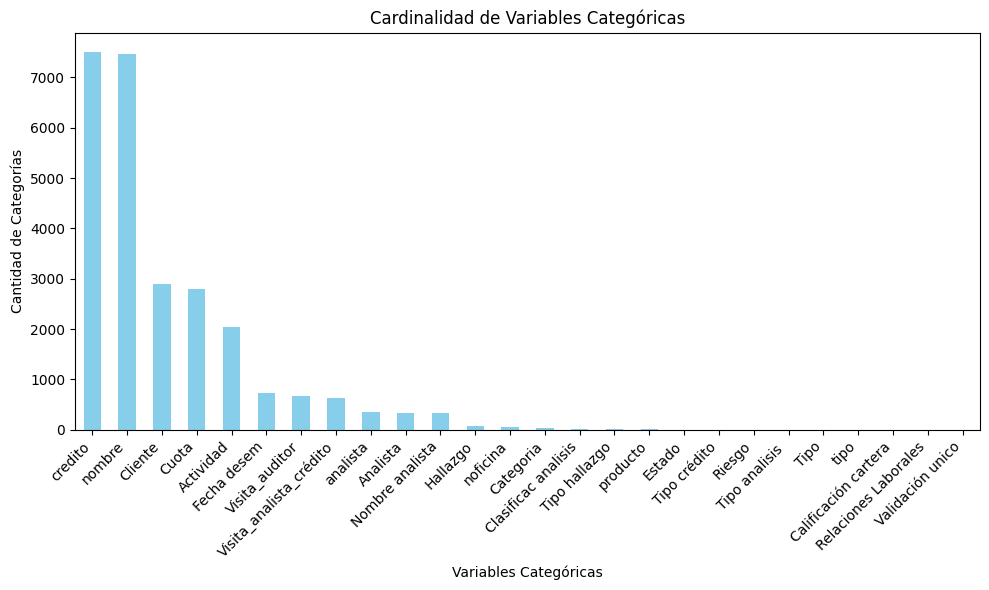

Análisis exploratorio de variables categóricas completado. Resumen y gráfica guardados.


In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
exploratory_df['Cantidad de Categorías'].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Cardinalidad de Variables Categóricas')
plt.xlabel('Variables Categóricas')
plt.ylabel('Cantidad de Categorías')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Cardinalidad_Variables_Categoricas.png')
plt.show()

print("Análisis exploratorio de variables categóricas completado. Resumen y gráfica guardados.")

In [106]:
# Extracción de características temporales
fecha_cols = merged_df.select_dtypes(include=['datetime']).columns

for col in fecha_cols:
    merged_df[f'{col}_year'] = merged_df[col].dt.year
    merged_df[f'{col}_month'] = merged_df[col].dt.month
    merged_df[f'{col}_day'] = merged_df[col].dt.day
    merged_df[f'{col}_weekday'] = merged_df[col].dt.weekday
    merged_df[f'{col}_is_weekend'] = merged_df[col].dt.weekday.isin([5, 6]).astype(int)

# Eliminar las columnas originales de tipo datetime
merged_df.drop(columns=fecha_cols, inplace=True)

In [107]:
# Verificar los nombres de las columnas del DataFrame para identificar la columna objetivo
print("Nombres de las columnas en el DataFrame fusionado:")
print(merged_df.columns.tolist())

Nombres de las columnas en el DataFrame fusionado:
['zona', 'coficina', 'noficina', 'credito', 'id', 'nombre', 'analista', 'saldo', 'monto', 'plazo', 'vcuota', 'tasa', 'producto', 'tipo', 'id_missing', 'Num', 'ID_modif', 'Cliente', 'Analista', 'Nombre analista', 'Tipo crédito', 'Fecha desem', 'Visita_analista_crédito', 'Visita_auditor', 'Actividad', 'Monto', 'Cuota', 'Plazo', 'Categoria', 'Hallazgo', 'Tipo hallazgo', 'Riesgo', 'Calificación cartera', 'Relaciones Laborales', 'zona ', 'Regional', 'Validación unico', 'Tipo analisis ', 'Clasificac analisis', 'Estado', 'Año', 'Tipo', 'Cliente_missing', 'Tipo crédito_missing', 'Fecha desem_missing', 'Visita_analista_crédito_missing', 'Visita_auditor_missing', 'Actividad_missing', 'Hallazgo_missing', 'Tipo hallazgo_missing', 'Riesgo_missing', 'Calificación cartera_missing', 'Relaciones Laborales_missing', 'Validación unico_missing', 'Tipo analisis _missing', 'Clasificac analisis_missing', 'Estado_missing', 'Tipo_missing', 'finicio_year', 'fin

In [108]:

# Verificar la presencia de la columna 'Riesgo' antes de continuar
print("Verificación de la columna 'Riesgo' después de la reconstrucción:")
print('Riesgo' in merged_df.columns)


Verificación de la columna 'Riesgo' después de la reconstrucción:
True


In [109]:

# Extraer componentes temporales de la columna 'Fecha desem'
if 'Fecha desem' in merged_df.columns:
    merged_df['Fecha desem'] = pd.to_datetime(merged_df['Fecha desem'], errors='coerce')
    merged_df['Fecha_desem_year'] = merged_df['Fecha desem'].dt.year
    merged_df['Fecha_desem_month'] = merged_df['Fecha desem'].dt.month
    merged_df['Fecha_desem_day'] = merged_df['Fecha desem'].dt.day
    merged_df['Fecha_desem_weekday'] = merged_df['Fecha desem'].dt.weekday
    merged_df['Fecha_desem_is_weekend'] = merged_df['Fecha desem'].dt.weekday.isin([5, 6]).astype(int)
    # Eliminar la columna original de fecha
    merged_df.drop(columns=['Fecha desem'], inplace=True)

# Convertir los valores de la columna 'Riesgo' a su formato numérico adecuado
riesgo_mapping = {
    '1 - Alto': 1,
    '2 - Medio': 2,
    '3 - Bajo': 3,
    '4 - Otro': 4,
    'No aplica': 4  # Asignar 'No aplica' al valor '4' (Otro)
}
if 'Riesgo' in merged_df.columns:
    merged_df['Riesgo'] = merged_df['Riesgo'].map(riesgo_mapping)
    print("Valores de la columna 'Riesgo' convertidos correctamente a formato numérico.")
else:
    print("La columna 'Riesgo' no se encuentra en el DataFrame. Por favor verifica el nombre de la columna.")

# Codificar la columna 'Riesgo' como una variable ordinal
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

ordinal_encoder = OrdinalEncoder(categories=[[1, 2, 3, 4]])
if 'Riesgo' in merged_df.columns:
    merged_df['Riesgo_encoded'] = ordinal_encoder.fit_transform(merged_df[['Riesgo']])
    # Eliminar la columna original 'Riesgo'
    merged_df.drop(columns=['Riesgo'], inplace=True)
    print("Columna 'Riesgo' codificada correctamente como variable ordinal.")
else:
    print("La columna 'Riesgo' no se encuentra en el DataFrame. Por favor verifica el nombre de la columna.")

# Aplicar Label Encoding solo a las variables categóricas que no son numéricas, excluyendo 'Riesgo_encoded'
categorical_cols = [col for col in categorical_cols_merged if col in merged_df.columns and merged_df[col].dtype == 'object' and col != 'Riesgo_encoded']

# Imprimir las columnas que se van a codificar con Label Encoding
print("Columnas seleccionadas para Label Encoding:", categorical_cols)

label_encoder = LabelEncoder()
encoding_maps = {}

if categorical_cols:
    for col in categorical_cols:
        print(f"Aplicando Label Encoding a la columna: {col}")
        merged_df[col + '_encoded'] = label_encoder.fit_transform(merged_df[col].astype(str))
        # Guardar el mapeo de los valores originales y los valores codificados
        encoding_maps[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    # Guardar los mapeos de codificación
import json
encoding_maps_df = pd.DataFrame.from_dict(encoding_maps, orient='index').transpose()
encoding_maps_df.to_excel('encoding_maps.xlsx', index=False)

# Guardar el dataset codificado en una nueva celda
print("Preparando para guardar el dataset final...")

# Guardar el dataset codificado final
merged_df.to_excel('Dataset_CodificadoFINAL4.xlsx', index=False)
print("Dataset codificado final guardado.")

Valores de la columna 'Riesgo' convertidos correctamente a formato numérico.
Columna 'Riesgo' codificada correctamente como variable ordinal.
Columnas seleccionadas para Label Encoding: ['noficina', 'credito', 'nombre', 'analista', 'producto', 'tipo', 'Cliente', 'Analista', 'Nombre analista', 'Tipo crédito', 'Visita_analista_crédito', 'Visita_auditor', 'Actividad', 'Cuota', 'Categoria', 'Hallazgo', 'Tipo hallazgo', 'Calificación cartera', 'Relaciones Laborales', 'Validación unico', 'Tipo analisis ', 'Clasificac analisis', 'Estado', 'Tipo']
Aplicando Label Encoding a la columna: noficina
Aplicando Label Encoding a la columna: credito
Aplicando Label Encoding a la columna: nombre
Aplicando Label Encoding a la columna: analista
Aplicando Label Encoding a la columna: producto
Aplicando Label Encoding a la columna: tipo
Aplicando Label Encoding a la columna: Cliente
Aplicando Label Encoding a la columna: Analista
Aplicando Label Encoding a la columna: Nombre analista
Aplicando Label Encodin

In [112]:
# Análisis de la distribución de Riesgo
print("Análisis de la distribución de la columna 'Riesgo_encoded':")
risk_distribution = merged_df['Riesgo_encoded'].value_counts()
print(risk_distribution)

# Identificar los clientes más y menos riesgosos por agencia (noficina), seleccionando una muestra exacta y manteniendo un orden consistente
top_risk_clients = merged_df.sort_values(by=['noficina', 'Riesgo_encoded', 'id'], ascending=[True, True, True]).groupby('noficina').head(15).reset_index(drop=True)
low_risk_clients = merged_df.sort_values(by=['noficina', 'Riesgo_encoded', 'id'], ascending=[True, False, True]).groupby('noficina').head(5).reset_index(drop=True)

# Identificar las dos agencias con mayor riesgo promedio
agency_risk = merged_df.groupby('noficina')['Riesgo_encoded'].mean().sort_values(ascending=False).head(2)
print("Agencias con mayor riesgo promedio:")
print(agency_risk)

# Crear un diccionario de datos para las variables codificadas
encoding_maps_df = pd.DataFrame.from_dict(encoding_maps, orient='index').transpose()

# Guardar todos los resultados en un único archivo Excel con diferentes hojas
with pd.ExcelWriter('Analisis_Riesgo_Clientes_AgenciasFinal.xlsx') as writer:
    top_risk_clients.to_excel(writer, sheet_name='Top_Risk_Clients', index=False)
    low_risk_clients.to_excel(writer, sheet_name='Low_Risk_Clients', index=False)
    agency_risk.to_excel(writer, sheet_name='Agency_Risk_Analysis')
    risk_distribution.to_excel(writer, sheet_name='Risk_Distribution')
    encoding_maps_df.to_excel(writer, sheet_name='Encoding_Dictionary', index=False)

print("Análisis de riesgo y clientes más y menos riesgosos guardados en un único archivo, incluyendo el diccionario de datos.")

Análisis de la distribución de la columna 'Riesgo_encoded':
Riesgo_encoded
1.0    191961
3.0    186986
2.0     60788
0.0     48124
Name: count, dtype: int64
Agencias con mayor riesgo promedio:
noficina
santander de quilichao    2.795918
facatativa                2.750000
Name: Riesgo_encoded, dtype: float64
Análisis de riesgo y clientes más y menos riesgosos guardados en un único archivo, incluyendo el diccionario de datos.


In [117]:
# División de los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Filtrar las columnas no numéricas que puedan causar problemas e imputar valores faltantes
X = merged_df.select_dtypes(include=[np.number]).drop(columns=['Riesgo_encoded'])
X = X.fillna(X.median())  # Imputar valores faltantes con la mediana
y = merged_df['Riesgo_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Construcción del pipeline para el modelo de clasificación
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
])

# Entrenamiento del modelo
pipeline.fit(X_train, y_train)

# Predicción y evaluación del modelo
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

In [86]:
# Extraer componentes temporales de la columna 'Fecha desem'
if 'Fecha desem' in merged_df.columns:
    merged_df['Fecha desem'] = pd.to_datetime(merged_df['Fecha desem'], errors='coerce')
    merged_df['Fecha_desem_year'] = merged_df['Fecha desem'].dt.year
    merged_df['Fecha_desem_month'] = merged_df['Fecha desem'].dt.month
    merged_df['Fecha_desem_day'] = merged_df['Fecha desem'].dt.day
    merged_df['Fecha_desem_weekday'] = merged_df['Fecha desem'].dt.weekday
    merged_df['Fecha_desem_is_weekend'] = merged_df['Fecha desem'].dt.weekday.isin([5, 6]).astype(int)
    # Eliminar la columna original de fecha
    merged_df.drop(columns=['Fecha desem'], inplace=True)

# Convertir los valores de la columna 'Riesgo' a su formato numérico adecuado
riesgo_mapping = {
    '1 - Alto': 1,
    '2 - Medio': 2,
    '3 - Bajo': 3,
    '4 - Otro': 4,
    'No aplica': 4  # Asignar 'No aplica' al valor '4' (Otro)
}
if 'Riesgo' in merged_df.columns:
    merged_df['Riesgo'] = merged_df['Riesgo'].map(riesgo_mapping)
    print("Valores de la columna 'Riesgo' convertidos correctamente a formato numérico.")
else:
    print("La columna 'Riesgo' no se encuentra en el DataFrame. Por favor verifica el nombre de la columna.")

# Codificar la columna 'Riesgo' como una variable ordinal
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

ordinal_encoder = OrdinalEncoder(categories=[[1, 2, 3, 4]])
if 'Riesgo' in merged_df.columns:
    merged_df['Riesgo_encoded'] = ordinal_encoder.fit_transform(merged_df[['Riesgo']])
    # Eliminar la columna original 'Riesgo'
    merged_df.drop(columns=['Riesgo'], inplace=True)
    print("Columna 'Riesgo' codificada correctamente como variable ordinal.")
else:
    print("La columna 'Riesgo' no se encuentra en el DataFrame. Por favor verifica el nombre de la columna.")

# Aplicar Label Encoding para todas las demás variables categóricas, excluyendo 'Riesgo_encoded'
categorical_cols = [col for col in categorical_cols_merged if col in merged_df.columns and col != 'Riesgo_encoded']

# Imprimir las columnas que se van a codificar con Label Encoding
print("Columnas seleccionadas para Label Encoding:", categorical_cols)

label_encoder = LabelEncoder()

if categorical_cols:
    for col in categorical_cols:
        print(f"Aplicando Label Encoding a la columna: {col}")
        merged_df[col + '_encoded'] = label_encoder.fit_transform(merged_df[col].astype(str))



C:\Users\alvar\AppData\Local\Temp\ipykernel_15588\4162041391.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['Fecha desem'] = pd.to_datetime(merged_df['Fecha desem'], errors='coerce')


Valores de la columna 'Riesgo' convertidos correctamente a formato numérico.
Columna 'Riesgo' codificada correctamente como variable ordinal.
Columnas seleccionadas para Label Encoding: ['noficina', 'credito', 'nombre', 'analista', 'producto', 'tipo', 'Cliente', 'Analista', 'Nombre analista', 'Tipo crédito', 'Visita_analista_crédito', 'Visita_auditor', 'Actividad', 'Cuota', 'Categoria', 'Hallazgo', 'Tipo hallazgo', 'Calificación cartera', 'Relaciones Laborales', 'Validación unico', 'Tipo analisis ', 'Clasificac analisis', 'Estado', 'Tipo']
Aplicando Label Encoding a la columna: noficina
Aplicando Label Encoding a la columna: credito
Aplicando Label Encoding a la columna: nombre
Aplicando Label Encoding a la columna: analista
Aplicando Label Encoding a la columna: producto
Aplicando Label Encoding a la columna: tipo
Aplicando Label Encoding a la columna: Cliente
Aplicando Label Encoding a la columna: Analista
Aplicando Label Encoding a la columna: Nombre analista
Aplicando Label Encodin

In [87]:
# Guardar el dataset codificado final
merged_df.to_excel('Dataset_CodificadoFINAL2.xlsx', index=False)
print("Dataset codificado final guardado.")

Dataset codificado final guardado.


In [72]:
# Análisis de la distribución de Riesgo
print("Análisis de la distribución de la columna 'Riesgo_encoded':")
risk_distribution = merged_df['Riesgo_encoded'].value_counts()
print(risk_distribution)

Análisis de la distribución de la columna 'Riesgo_encoded':
Riesgo_encoded
1.0    191961
3.0    186986
2.0     60788
0.0     48124
Name: count, dtype: int64


In [73]:
# Identificar los clientes más y menos riesgosos por agencia (noficina)
top_risk_clients = merged_df.sort_values(by=['Riesgo_encoded'], ascending=True).groupby('noficina').head(15)
low_risk_clients = merged_df.sort_values(by=['Riesgo_encoded'], ascending=False).groupby('noficina').head(5)

# Guardar los clientes más y menos riesgosos
top_risk_clients.to_excel('Top_Risk_Clients.xlsx', index=False)
low_risk_clients.to_excel('Low_Risk_Clients.xlsx', index=False)
print("Clientes más y menos riesgosos guardados.")


KeyError: 'noficina'